Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 1.707839 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.66e-02, 9.78e-03, 6.97e-03, 3.54e+00, 2.85e-01]    [2.66e-02, 9.78e-03, 6.97e-03, 3.54e+00, 2.85e-01]    []  
1000      [2.32e-03, 1.51e-03, 8.12e-04, 2.49e-02, 4.89e-02]    [2.32e-03, 1.51e-03, 8.12e-04, 2.49e-02, 4.89e-02]    []  
2000      [1.69e-03, 2.37e-03, 9.44e-04, 1.68e-02, 3.29e-02]    [1.69e-03, 2.37e-03, 9.44e-04, 1.68e-02, 3.29e-02]    []  
3000      [1.64e-03, 2.71e-03, 1.04e-03, 1.28e-02, 2.93e-02]    [1.64e-03, 2.71e-03, 1.04e-03, 1.28e-02, 2.93e-02]    []  
4000      [1.59e-03, 2.84e-03, 7.47e-04, 1.03e-02, 2.03e-02]    [1.59e-03, 2.84e-03, 7.47e-04, 1.03e-02, 2.03e-02]    []  
5000      [2.01e-03, 2.98e-03, 7.68e-04, 6.41e-03, 9.10e-03]    [2.01e-03, 2.98e-03, 7.68e-04, 6.41e-03, 9.10e-03]    []  
6000      [1.87e-03, 2.57e-03, 7.11e-04, 4.30e-03, 5.28e-03]    [1.

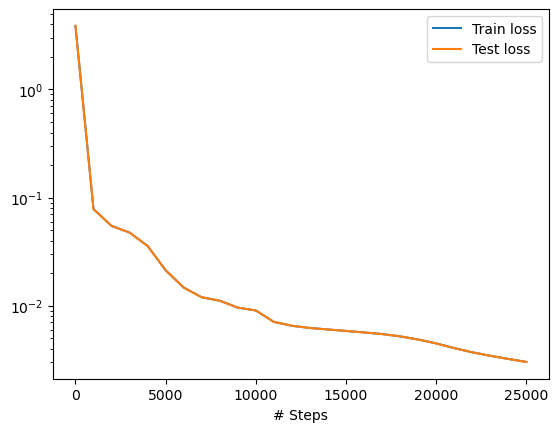

In [1]:
import deepxde as dde
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.animation as animation

nu = 0.1

def pde(x, y):
 u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]
 u_t = dde.grad.jacobian(y, x, i=0, j=2)
 v_t = dde.grad.jacobian(y, x, i=1, j=2)
 u_x = dde.grad.jacobian(y, x, i=0, j=0)
 u_y = dde.grad.jacobian(y, x, i=0, j=1)
 v_x = dde.grad.jacobian(y, x, i=1, j=0)
 v_y = dde.grad.jacobian(y, x, i=1, j=1)
 u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
 u_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
 v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
 v_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
 p_x = dde.grad.jacobian(y, x, i=2, j=0)
 p_y = dde.grad.jacobian(y, x, i=2, j=1)
 
 f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
 g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
 h = u_x + v_y
 return [f, g, h]

# Load data
data = scipy.io.loadmat('cylinder_wake.mat')
U_star = data['U_star']
P_star = data['p_star']
t_star = data['t']
X_star = data['X_star']

N = X_star.shape[0]
T = t_star.shape[0]

XX = np.tile(X_star[:, 0:1], (1, T))
YY = np.tile(X_star[:, 1:2], (1, T))
TT = np.tile(t_star, (1, N)).T

UU = U_star[:, 0, :]
VV = U_star[:, 1, :]
PP = P_star

x = XX.flatten()[:, None]
y = YY.flatten()[:, None]
t = TT.flatten()[:, None]
u = UU.flatten()[:, None]
v = VV.flatten()[:, None]

# Training Data
N_train = 5000
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

# Define geometry and time domain
geom = dde.geometry.Rectangle([x.min(), y.min()], [x.max(), y.max()])
timedomain = dde.geometry.TimeDomain(t.min(), t.max())
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define boundary conditions
def boundary(_, on_boundary):
 return on_boundary

# Initial and boundary conditions
ic_u = dde.icbc.PointSetBC(np.hstack((x_train, y_train, t_train)), u_train, component=0)
ic_v = dde.icbc.PointSetBC(np.hstack((x_train, y_train, t_train)), v_train, component=1)

# Define the neural network
net = dde.maps.FNN([3] + [64]*4 + [3], "tanh", "Glorot normal")

# Define the model
data = dde.data.TimePDE(
 geomtime, pde, [ic_u, ic_v], num_domain=5000, num_boundary=5000
)
model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)

model.compile("L-BFGS")
model.train()


dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [4]:

X = geomtime.uniform_points(5000)
y = model.predict(X)

print(X.shape)
print(y.shape)

(5460, 3)
(5460, 3)


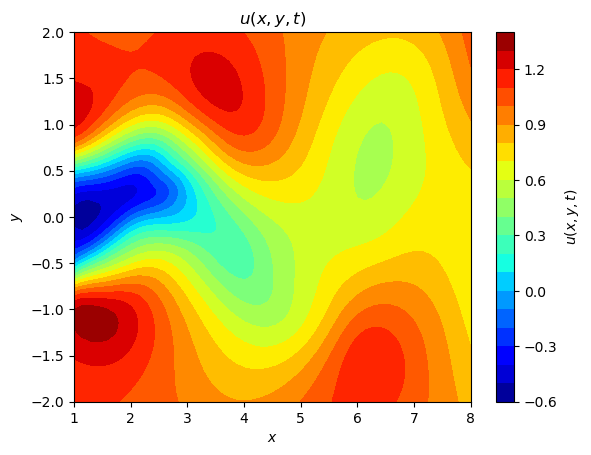

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming you have a trained model
# Replace the following line with the actual model you have trained
# from your_model_file import model

# Example data (replace this with your actual data)
# X contains columns for x, y, and t
# Extracting x, y, t
x = X[:, 0]
y = X[:, 1]
t = X[:, 2]

# Create grid for plotting
x_unique = np.linspace(min(x), max(x), 50)
y_unique = np.linspace(min(y), max(y), 100)
XX_test, YY_test = np.meshgrid(x_unique, y_unique)

# Unique time steps
t_star = np.unique(t)

# Initialize plot
fig, ax = plt.subplots()

# Compute initial plot to determine color scale
X_test_initial = np.hstack((XX_test.flatten()[:, None], YY_test.flatten()[:, None], np.full((XX_test.size, 1), t_star[0])))
u_out_initial = model.predict(X_test_initial)[:, 0]
u_plot_initial = u_out_initial.reshape(XX_test.shape)

# Create initial plot and colorbar
cax = ax.contourf(XX_test, YY_test, u_plot_initial, levels=20, cmap='jet')
cbar = plt.colorbar(cax, ax=ax)
cbar.set_label(r'$u(x, y, t)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'$u(x, y, t)$')

# Set consistent axis limits
ax.set_xlim([XX_test.min(), XX_test.max()])
ax.set_ylim([YY_test.min(), YY_test.max()])

def animate(i):
 ax.clear()
 current_t = t_star[i]
 X_test = np.hstack((XX_test.flatten()[:, None], YY_test.flatten()[:, None], np.full((XX_test.size, 1), current_t)))
 u_out = model.predict(X_test)[:, 0]
 u_plot = u_out.reshape(XX_test.shape)
 cax = ax.contourf(XX_test, YY_test, u_plot, levels=20, cmap='jet')
 ax.set_xlabel(r'$x$')
 ax.set_ylabel(r'$y$')
 ax.set_title(r'$u(x, y, t)$')
 return cax.collections

# Create animation
ani = FuncAnimation(fig, animate, frames=len(t_star), interval=200, blit=True)

# Save animation
ani.save('u_field_animation.gif', writer='imagemagick')

plt.show()


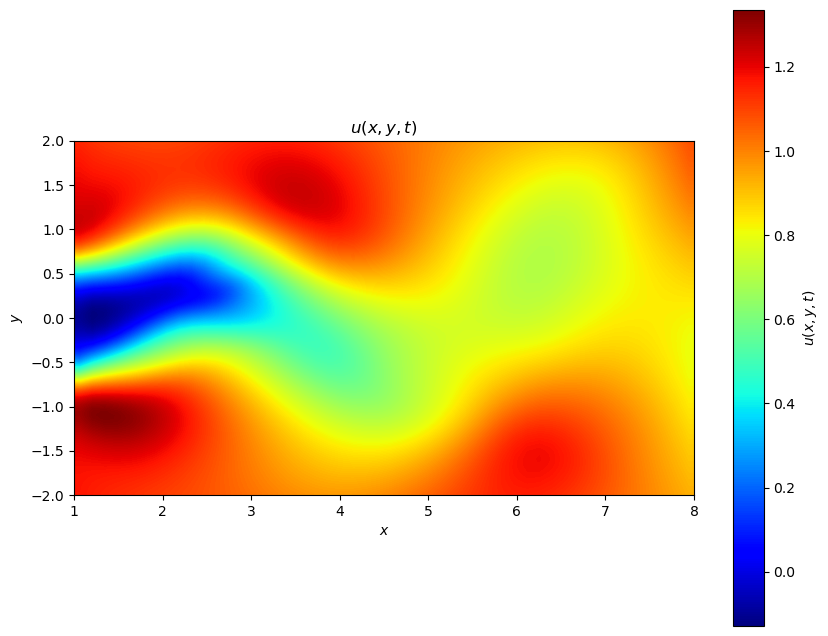

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Import your trained model here
# from your_model_file import model

# Example data (replace this with your actual data)
# X contains columns for x, y, and t
# Replace with your actual data array
# X = np.array([[x_val, y_val, t_val] for x_val, y_val, t_val in zip(x, y, t)])
x = X[:, 0]
y = X[:, 1]
t = X[:, 2]

# Create grid for plotting
x_unique = np.linspace(min(x), max(x), 50) # Reduced resolution for performance
y_unique = np.linspace(min(y), max(y), 100)
XX_test, YY_test = np.meshgrid(x_unique, y_unique)

# Unique time steps
t_star = t

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 8))

# Generate initial data for the first time step
X_test_initial = np.hstack((XX_test.flatten()[:, None], YY_test.flatten()[:, None], np.full((XX_test.size, 1), t_star[0])))
u_out_initial = model.predict(X_test_initial)[:, 0] # Replace with actual model prediction
u_plot_initial = u_out_initial.reshape(XX_test.shape)

# Plot initial frame
c = ax.imshow(u_plot_initial, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()), origin='lower', cmap='jet', interpolation='bilinear', animated=True)

# Add colorbar
cbar = plt.colorbar(c, ax=ax)
cbar.set_label(r'$u(x, y, t)$')

# Set axis labels and title
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'$u(x, y, t)$')

# Set consistent axis limits
ax.set_xlim(x_unique.min(), x_unique.max())
ax.set_ylim(y_unique.min(), y_unique.max())
ax.set_aspect('equal')

def animate(i):
 current_t = t_star[i]
 X_test = np.hstack((XX_test.flatten()[:, None], YY_test.flatten()[:, None], np.full((XX_test.size, 1), current_t)))
 u_out = model.predict(X_test)[:, 0] # Replace with actual model prediction
 u_plot = u_out.reshape(XX_test.shape)
 c.set_data(u_plot)
 c.set_clim(vmin=np.min(u_plot), vmax=np.max(u_plot)) # Optional: Adjust color limits dynamically
 return c,

# Create animation
ani = FuncAnimation(fig, animate, frames=len(t_star), interval=150, blit=True)

# Save animation
ani.save('u_animat.gif', writer='imagemagick')

plt.show()
